In [13]:
import torch
import numpy as np
import os
from torch.utils import data
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models

In [14]:
def imshow(img):
    plt.figure('image')
    plt.imshow(img)
    plt.show()

In [15]:
def read_somkedata(data_dir, is_train=True):
    data, labels = [], []
    for label in ('smoke', 'non'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'val',
                                   label)
        for file in os.listdir(folder_name):
            img = Image.open(os.path.join(folder_name, file))
            data.append(img)
            labels.append(1 if label == 'smoke' else 0)
    return data, labels

训练集数目： 1300
测试集数目： 80
标签： 1


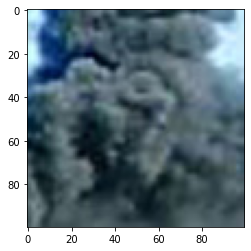

标签： 1


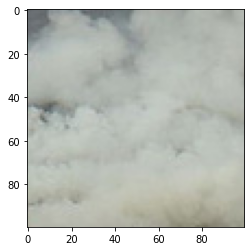

In [16]:
data_dir = "./data/smokedata/"

train_data = read_somkedata(data_dir, is_train=True)
test_data = read_somkedata(data_dir, is_train=False)

print('训练集数目：', len(train_data[0]))
print('测试集数目：', len(test_data[0]))

for x, y in zip(train_data[0][:2], train_data[1][:2]):
    print('标签：', y)
    imshow(x)

In [17]:
# coding: utf-8
from torch.utils.data import Dataset
"""
构建Dataset子类，
pytorch读取图片，主要是通过Dataset类，Dataset类作为所有的datasets的基类存在，所有的datasets都需要继承它，类似于c++中的虚基类。

"""
class ImgDataset(Dataset): # 继承Dataset类
    def __init__(self, data_dir, is_train, transform=None, target_transform=None):
        data = read_somkedata(data_dir, is_train=is_train)
        self.imgs = data[0]
        self.labels = data[1]
        self.transform = transform
        self.target_transform = target_transform
        self.length = len(self.imgs) - 2

    def __getitem__(self, index):
        img = [self.imgs[index], self.imgs[index+1], self.imgs[index+2]]
        label = self.labels[index]

        if self.transform is not None:
            img = [self.transform(i) for i in img]
            
        clip = torch.stack(img, 0)

        return clip, label

    def __len__(self):
        return self.length

In [18]:
trans = transforms.Compose(
        [transforms.Resize([112,112]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = ImgDataset(data_dir, is_train=True, transform=trans)
test_set = ImgDataset(data_dir, is_train=False, transform=trans)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=3,
                                              shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                              shuffle=False, num_workers=0)

In [19]:
class cnnlstm(nn.Module):
    def __init__(self, pretrained_=False):
        super(cnnlstm, self).__init__()
        self.res18 = models.resnet18(pretrained=True)
        self.res18.fc = nn.Linear(512, 256)
        self.lstm = nn.LSTM(256, 256)
        self.classifier = nn.Linear(256,2)

    def forward(self, x):
        x = self.res18(x)
        # pdb.set_trace()
        # N C
#         print(x.shape)
        x = x.view(-1, 3, 256) # T N C
#         print(x.shape)
        x = x.permute(1, 0, 2)
#         print(x.shape)
        y, (hx, cx) = self.lstm(x)
#         print(y.shape)
        x = y[-1, :, :]
#         print(x.shape)
        x = x.squeeze(axis=0)
#         print(x.shape)
        x = self.classifier(x)
#         print(x.shape)
        return x

In [20]:
from tqdm.auto import tqdm
def train_epoch(net, train_loader, optimizer, device):
    net.train()
    epoch_loss = 0.
    epoch_acc = 0.
    nums_label = 0
    
    for X, y in tqdm(train_loader):
        n = X.size(0)
        X = X.view(n*3, 3, 112, 112)
        X, y = X.to(device), y.to(device)
#         print(X.shape)
        outputs = net(X)
#         print(outputs.shape)
#         print(outputs)
        _, preds = torch.max(outputs, 1)
        l = loss(outputs, y)
        optimizer.zero_grad()
        l.sum().backward()
        optimizer.step()

        with torch.no_grad():
            epoch_loss += l.sum() / X.size(0)
            num_correct = torch.sum(preds == y.data)
            epoch_acc += num_correct
            nums_label += y.numel()
            
    epoch_loss, epoch_acc = epoch_loss/len(train_loader), epoch_acc/nums_label
    return epoch_loss, epoch_acc

In [21]:
def evaluation(net, test_loader, device):
    net.eval()
    epoch_loss = 0.
    epoch_acc = 0.
    nums_label = 0
    
    for X, y in test_loader:
        n = X.size(0)
        X = X.view(n*3, 3, 112, 112)
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, preds = torch.max(outputs, 1)
        l = loss(outputs, y)

        with torch.no_grad():
            epoch_loss += l.sum() / X.size(0)
            num_correct = torch.sum(preds == y.data)
            epoch_acc += num_correct
            nums_label += y.numel()
            
    epoch_loss, epoch_acc = epoch_loss/len(test_loader), epoch_acc/nums_label
    return epoch_loss, epoch_acc

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

net = cnnlstm()
net.to(device)
lr, num_epochs = 0.001, 10
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

print("training on", device)
for epoch in range(num_epochs):
    print('epoch {}'.format(epoch + 1))
    # training-----------------------------
    net.train()
    train_loss, train_acc = train_epoch(net, train_loader, optimizer, device)
    test_loss, test_acc = evaluation(net, test_loader, device)
    
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss, train_acc))
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(test_loss, test_acc))
   
    history["train_loss"].append(train_loss.cpu())
    history["train_acc"].append(train_acc.cpu())
    history["test_loss"].append(test_loss.cpu())
    history["test_acc"].append(test_acc.cpu())

training on cpu
epoch 1


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.214592, Acc: 0.633282
Test Loss: 0.170741, Acc: 0.743590
epoch 2


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.209798, Acc: 0.630200
Test Loss: 0.217581, Acc: 0.500000
epoch 3


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.190652, Acc: 0.708783
Test Loss: 0.148379, Acc: 0.846154
epoch 4


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.191680, Acc: 0.698767
Test Loss: 0.316058, Acc: 0.500000
epoch 5


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.194393, Acc: 0.704931
Test Loss: 0.141310, Acc: 0.884615
epoch 6


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.184132, Acc: 0.729584
Test Loss: 0.159809, Acc: 0.833333
epoch 7


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.188192, Acc: 0.731895
Test Loss: 0.235416, Acc: 0.602564
epoch 8


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.172970, Acc: 0.778120
Test Loss: 0.187328, Acc: 0.705128
epoch 9


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.177131, Acc: 0.761941
Test Loss: 0.116080, Acc: 0.897436
epoch 10


  0%|          | 0/433 [00:00<?, ?it/s]

Train Loss: 0.175339, Acc: 0.765794
Test Loss: 0.124382, Acc: 0.871795


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(history):
    fig, ax = plt.subplots()
    fig.autofmt_xdate() 
    plt.xlabel("epochs")
    plt.ylabel("loss")
    idx = [i+1 for i in range(len(history["train_loss"]))]
    
    l1, = plt.plot(idx,history["train_loss"], color="red")
    l2, = plt.plot(idx,history["test_loss"],color="green")
    plt.legend([l1, l2],
           ['train_loss', 'test_loss'],
           loc='upper right'
    )
    plt.show()

def plot_acc(history):
    fig, ax = plt.subplots()
    plt.xlabel("epochs")
    plt.ylabel("acc")
    idx = [i+1 for i in range(len(history["train_acc"]))]
    l1, = plt.plot(idx,history["train_acc"], color="red")
    l2, = plt.plot(idx,history["test_acc"],color="green")
    plt.legend([l1, l2],
           ['train_acc', 'test_acc'],
           loc='upper right'
    )
    plt.show()

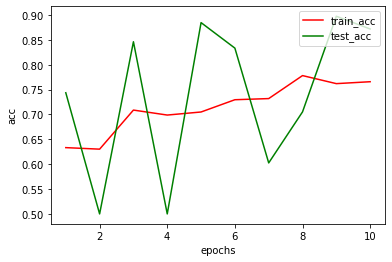

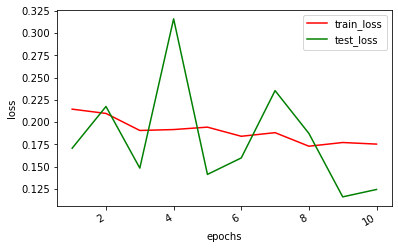

In [24]:
plot_acc(history=history)
plot_loss(history=history)